# Single LGBM for ASHRAE

This is a simple kernel which does the following:
- **preprocessing**: during data import, minimise memory usage (typecasting) given the size of the dataset and the instance's RAM, correct weather data (timezone alignment, imputation) and log-transform the target.
- **cleaning**: drops bad readings in site 0.
- **FE**: basic temporal and lag features, to avoid overfitting.
- **modelling**: trains a single LGBM with (unshuffled) k-fold CV (plus a random forest for reference).
- **inference**: bagging of model's versions trained on each CV fold.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import os
import datetime
import warnings
import gc

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

from tqdm.notebook import tqdm

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path = '../input/ashrae-energy-prediction'

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../input/ashrae-energy-prediction/sample_submission.csv
../input/ashrae-energy-prediction/building_metadata.csv
../input/ashrae-energy-prediction/weather_train.csv
../input/ashrae-energy-prediction/weather_test.csv
../input/ashrae-energy-prediction/train.csv
../input/ashrae-energy-prediction/test.csv


# Utilities

Memory reduction adapted from [this kernel.](https://www.kaggle.com/purist1024/ashrae-simple-data-cleanup-lb-1-08-no-leaks/notebook)

In [3]:
def reduce_mem(df):
    result = df.copy()
    for col in result.columns:
        col_data = result[col]
        dn = col_data.dtype.name
        if not dn.startswith("datetime"):
            if dn == "object":  # only object feature has low cardinality
                result[col] = pd.to_numeric(col_data.astype("category").cat.codes, downcast="unsigned")
            elif dn.startswith("int") | dn.startswith("uint"):
                if col_data.min() >= 0:
                    result[col] = pd.to_numeric(col_data, downcast="unsigned")
                else:
                    result[col] = pd.to_numeric(col_data, downcast='integer')
            else:
                result[col] = pd.to_numeric(col_data, downcast='float')
    return result

Routine to add lag features to weather dataset, adapted from [this kernel](https://www.kaggle.com/corochann/ashrae-training-lgbm-by-meter-type/notebook).

In [4]:
def add_lag_features(weather_df, window=3):
    group_df = weather_df.groupby('site_id')
    cols = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr']
    rolled = group_df[cols].rolling(window=window, min_periods=0)
    lag_mean = rolled.mean().reset_index().astype(np.float16)
    lag_max = rolled.max().reset_index().astype(np.float16)
    lag_min = rolled.min().reset_index().astype(np.float16)
    for col in cols:
        weather_df[f'{col}_min_lag{window}'] = lag_min[col]
        weather_df[f'{col}_mean_lag{window}'] = lag_mean[col]
        weather_df[f'{col}_max_lag{window}'] = lag_max[col]
    return weather_df

# Load data

In [5]:
def load_data(source='train'):
    assert source in ['train','test']
    df = pd.read_csv(f'{path}/{source}.csv', parse_dates=['timestamp'])
    return reduce_mem(df)

def load_building():
    df = pd.read_csv(f'{path}/building_metadata.csv').fillna(-1)
    return reduce_mem(df)

def load_weather(source='train', fix_timezone=True, impute=True, add_lag=True):
    assert source in ['train','test']
    df = pd.read_csv(f'{path}/weather_{source}.csv', parse_dates=['timestamp'])
    if fix_timezone:
        offsets = [5,0,9,6,8,0,6,6,5,7,8,6,0,7,6,6]
        offset_map = {site: offset for site, offset in enumerate(offsets)}
        df.timestamp = df.timestamp - pd.to_timedelta(df.site_id.map(offset_map), unit='h')
    if impute:
        site_dfs = []
        for site in df.site_id.unique():
            if source == 'train':
                new_idx = pd.date_range(start='2016-1-1', end='2016-12-31-23', freq='H')
            else:
                new_idx = pd.date_range(start='2017-1-1', end='2018-12-31-23', freq='H')
            site_df = df[df.site_id == site].set_index('timestamp').reindex(new_idx)
            site_df.site_id = site
            for col in [c for c in site_df.columns if c != 'site_id']:
                site_df[col] = site_df[col].interpolate(limit_direction='both', method='linear')
                site_df[col] = site_df[col].fillna(df[col].median())
            site_dfs.append(site_df)
        df = pd.concat(site_dfs)
        df['timestamp'] = df.index
        df = df.reset_index(drop=True)
        
    if add_lag:
        df = add_lag_features(df, window=3)
    
    return reduce_mem(df)

def merged_dfs(source='train', fix_timezone=True, impute=True, add_lag=True):
    df = load_data(source=source).merge(load_building(), on='building_id', how='left')
    df = df.merge(load_weather(source=source, fix_timezone=True, impute=True, add_lag=True),
                 on=['site_id','timestamp'], how='left')
    if source == 'train':
        X = df.drop('meter_reading', axis=1)  
        y = np.log1p(df.meter_reading)  # log-transform of target
        return X, y
    elif source == 'test':
        return df

In [6]:
%%time
X_train, y_train = merged_dfs()
X_train.head()

CPU times: user 22.1 s, sys: 5.71 s, total: 27.8 s
Wall time: 34.8 s


,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,...,air_temperature_max_lag3,cloud_coverage_min_lag3,cloud_coverage_mean_lag3,cloud_coverage_max_lag3,dew_temperature_min_lag3,dew_temperature_mean_lag3,dew_temperature_max_lag3,precip_depth_1_hr_min_lag3,precip_depth_1_hr_mean_lag3,precip_depth_1_hr_max_lag3
0,0,0,2016-01-01,0,0,7432,2008.0,-1.0,19.4,6.0,...,19.40625,6.0,6.0,6.0,19.40625,19.40625,19.40625,0.0,0.0,0.0
1,1,0,2016-01-01,0,0,2720,2004.0,-1.0,19.4,6.0,...,19.40625,6.0,6.0,6.0,19.40625,19.40625,19.40625,0.0,0.0,0.0
2,2,0,2016-01-01,0,0,5376,1991.0,-1.0,19.4,6.0,...,19.40625,6.0,6.0,6.0,19.40625,19.40625,19.40625,0.0,0.0,0.0
3,3,0,2016-01-01,0,0,23685,2002.0,-1.0,19.4,6.0,...,19.40625,6.0,6.0,6.0,19.40625,19.40625,19.40625,0.0,0.0,0.0
4,4,0,2016-01-01,0,0,116607,1975.0,-1.0,19.4,6.0,...,19.40625,6.0,6.0,6.0,19.40625,19.40625,19.40625,0.0,0.0,0.0


In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 27 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   building_id                  uint16        
 1   meter                        uint8         
 2   timestamp                    datetime64[ns]
 3   site_id                      uint8         
 4   primary_use                  uint8         
 5   square_feet                  uint32        
 6   year_built                   float32       
 7   floor_count                  float32       
 8   air_temperature              float32       
 9   cloud_coverage               float32       
 10  dew_temperature              float32       
 11  precip_depth_1_hr            float32       
 12  sea_level_pressure           float32       
 13  wind_direction               float32       
 14  wind_speed                   float32       
 15  air_temperature_min_lag3     float16       
 16

This corresponds to roughly a 50% improvement in memory usage, despite having added lag features.

# Preprocessing

Let us remove the first 141 days of electrical meter readings at site 0, which are mostly zero or contain anomalous spikes. This is the type of outlier which causes the most trouble and is comparatively easier to remove. We also extract some basic temporal features.

In [8]:
def _delete_bad_sitezero(X, y):
    cond = (X.timestamp > '2016-05-20') | (X.site_id != 0) | (X.meter != 0)
    X = X[cond]
    y = y.reindex_like(X)
    return X.reset_index(drop=True), y.reset_index(drop=True)

def _extract_temporal(X):
    X['hour'] = X.timestamp.dt.hour
    X['weekday'] = X.timestamp.dt.weekday
    # month and year cause overfit, could try other (holiday, business, etc.)
    return reduce_mem(X)

In [9]:
# preprocessing
X_train, y_train = _delete_bad_sitezero(X_train, y_train)
X_train = _extract_temporal(X_train)

# remove timestamp and other unimportant features
to_drop = ['timestamp','sea_level_pressure','wind_direction','wind_speed']
X_train.drop(to_drop, axis=1, inplace=True)

gc.collect()

57

# Modeling

Before training the LGBM, let us train a "baseline" random forest for comparison. We write small wrappers for each, to be passed to a CV routine.

In [10]:
def RF_wrapper(Xt, yt, Xv, yv, fold=-1):
    
    model = RandomForestRegressor(n_jobs=-1, n_estimators=40,
                              max_samples=200000, max_features=0.5,
                              min_samples_leaf=5, oob_score=False).fit(Xt, yt)
    print(f'Training fold {fold}...')
    
    score_train = np.sqrt(mean_squared_error(model.predict(Xt), yt))
    oof = model.predict(Xv)
    score = np.sqrt(mean_squared_error(oof, yv))
    print(f'Fold {fold}: training RMSLE: {score_train},   validation RMSLE: {score}\n')
    return model, oof, score

In [11]:
def LGBM_wrapper(Xt, yt, Xv, yv, fold=-1):
    
    dset = lgb.Dataset(Xt, label=yt, categorical_feature=cat_features)
    dset_val = lgb.Dataset(Xv, label=yv, categorical_feature=cat_features)
    
    params = {
        "objective": "regression",
        "boosting": "gbdt",
        "num_leaves": 500,
        "learning_rate": 0.04,
        "feature_fraction": 0.7,
        "subsample": 0.4,
        "metric": "rmse",
        "seed": 42,
        "n_jobs": -1,
        "verbose": -1
    }
    
    print(f'Fold {fold}')
    
    # filter some known warnings (open issue at https://github.com/microsoft/LightGBM/issues/3379)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", "categorical_column in param dict is overridden")
        warnings.filterwarnings("ignore", "Overriding the parameters from Reference Dataset")
        model = lgb.train(params,
                         train_set=dset,
                         num_boost_round=1000,
                         valid_sets=[dset, dset_val],
                         verbose_eval=200,
                         early_stopping_rounds=100,
                         categorical_feature=cat_features)
    
    oof = model.predict(Xv, num_iteration=model.best_iteration)
    score = np.sqrt(mean_squared_error(yv, oof))
    print(f'Fold {fold} validation RMSLE: {score}\n')
    return model, oof, score

Let us perform k-fold CV, without shuffling as this is a time series. An alternative would be to do a single train/validation split, possibly with a gap to mimic training/private split. Otherwise, one could try something like Time-series split CV.

In [12]:
def perform_CV(wrapper, n_splits=3):
    
    kf = KFold(n_splits=n_splits, shuffle=False)

    models = []
    scores = []
    oof_total = np.zeros(X_train.shape[0])


    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), start=1):
        Xt, yt = X_train.iloc[train_idx], y_train[train_idx]
        Xv, yv = X_train.iloc[val_idx], y_train[val_idx]
        model, oof, score = wrapper(Xt, yt, Xv, yv, fold)

        models.append(model)
        scores.append(score)
        oof_total[val_idx] = oof

    print('Training completed.')
    print(f'> Mean RMSLE across folds: {np.mean(scores)}, std: {np.std(scores)}')
    print(f'> OOF RMSLE: {np.sqrt(mean_squared_error(y_train, oof_total))}')
    return models, scores, oof_total

Let's train the random forest.

In [13]:
n_splits = 3

_, _, _ = perform_CV(RF_wrapper, n_splits=n_splits)

Training fold 1...
Fold 1: training RMSLE: 0.8611267316477558,   validation RMSLE: 1.1367056048709083

Training fold 2...
Fold 2: training RMSLE: 0.8835663917256341,   validation RMSLE: 1.0767358407752063

Training fold 3...
Fold 3: training RMSLE: 0.8106710913321011,   validation RMSLE: 1.1552281622182512

Training completed.
> Mean RMSLE across folds: 1.122889869288122, std: 0.033500418342160755
> OOF RMSLE: 1.1233894863731062


Now let's repeat this for LGBM.

In [14]:
cat_features = ['building_id','meter','site_id','primary_use','hour','weekday']

models, scores, oof_total = perform_CV(LGBM_wrapper, n_splits=n_splits)

Fold 1
Training until validation scores don't improve for 100 rounds
[200]	training's rmse: 0.7854	valid_1's rmse: 1.11766
Early stopping, best iteration is:
[170]	training's rmse: 0.801017	valid_1's rmse: 1.11759
Fold 1 validation RMSLE: 1.1175865805724514

Fold 2
Training until validation scores don't improve for 100 rounds
[200]	training's rmse: 0.81202	valid_1's rmse: 1.04374
Early stopping, best iteration is:
[188]	training's rmse: 0.81741	valid_1's rmse: 1.04346
Fold 2 validation RMSLE: 1.0434573400170135

Fold 3
Training until validation scores don't improve for 100 rounds
[200]	training's rmse: 0.736617	valid_1's rmse: 1.1475
Early stopping, best iteration is:
[130]	training's rmse: 0.788298	valid_1's rmse: 1.14266
Fold 3 validation RMSLE: 1.1426582584781555

Training completed.
> Mean RMSLE across folds: 1.101234059689207, std: 0.04211697409446891
> OOF RMSLE: 1.1020391533258782


## Feature importance

Let's see the average feature importance across models. We can use this to retroactively drop further superfluous features during preprocessing.

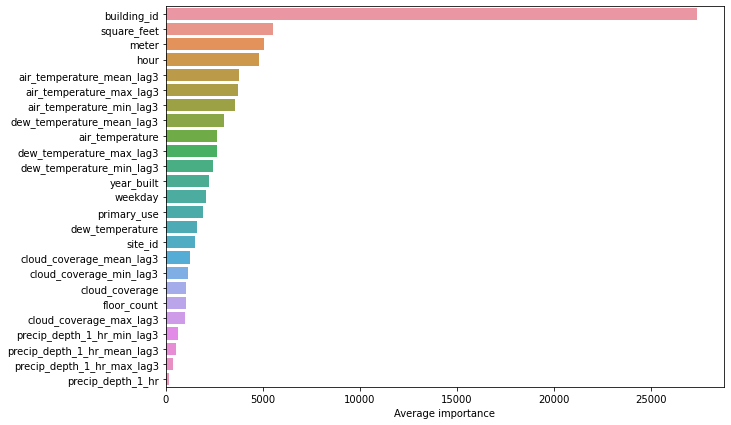

In [15]:
importance = pd.DataFrame([model.feature_importance() for model in models],
                          columns=X_train.columns,
                          index=[f'Fold {i}' for i in range(1, n_splits + 1)])
importance = importance.T
importance['Average importance'] = importance.mean(axis=1)
importance = importance.sort_values(by='Average importance', ascending=False)

plt.figure(figsize=(10,7))
sns.barplot(x='Average importance', y=importance.index, data=importance);

In [16]:
del X_train, y_train
gc.collect()

7821

# Test set, inference and submission

Let us load the test data and apply the same transformations as for the training set.

In [17]:
%%time
X_test = merged_dfs('test')

CPU times: user 45.2 s, sys: 10.6 s, total: 55.9 s
Wall time: 1min 10s


In [18]:
row_ids = X_test.row_id # for submission file
X_test = _extract_temporal(X_test)
X_test.drop(columns=['row_id','timestamp']+to_drop, inplace=True)

gc.collect()

34

In [19]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41697600 entries, 0 to 41697599
Data columns (total 25 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   building_id                  uint16 
 1   meter                        uint8  
 2   site_id                      uint8  
 3   primary_use                  uint8  
 4   square_feet                  uint32 
 5   year_built                   float32
 6   floor_count                  float32
 7   air_temperature              float32
 8   cloud_coverage               float32
 9   dew_temperature              float32
 10  precip_depth_1_hr            float32
 11  air_temperature_min_lag3     float16
 12  air_temperature_mean_lag3    float16
 13  air_temperature_max_lag3     float16
 14  cloud_coverage_min_lag3      float16
 15  cloud_coverage_mean_lag3     float16
 16  cloud_coverage_max_lag3      float16
 17  dew_temperature_min_lag3     float16
 18  dew_temperature_mean_lag3    float16
 19

Let's compute the predictions on the test set for each model, then average the results. This would improve the stability of the predictions, assuming the errors from each model are independent. Indeed, this gives a considerable boost in performance on PB.

We split the computation in batches, to keep memory usage within the limits. Naturally, we transform the predictions back into linear space with the inverse of the log-transform.

In [20]:
n_iterations = 20
batch_size = len(X_test) // n_iterations

preds = []
for i in tqdm(range(n_iterations)):
    start = i * batch_size
    fold_preds = [np.expm1(model.predict(X_test.iloc[start:start + batch_size], 
                                         num_iteration=model.best_iteration)) for model in models]
    preds.extend(np.mean(fold_preds, axis=0))

del X_test
gc.collect()

  0%|          | 0/20 [00:00<?, ?it/s]

44

Finally, save for submission and hope for the best.

In [21]:
submission = pd.DataFrame({'row_id':row_ids, 'meter_reading':np.clip(preds, 0, a_max=None)})
submission.to_csv('submission.csv', index=False)

We can check that the distribution of the predictions looks reasonable:

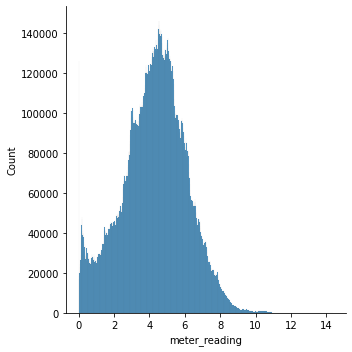

In [22]:
sns.displot(np.log1p(submission.meter_reading));

That's it. Do upvote this kernel if you found it of any use! 🖖

Below are some links to kernels I either found interesting or directly borrowed from.

# References

Instructive kernels:
- https://www.kaggle.com/purist1024/ashrae-simple-data-cleanup-lb-1-08-no-leaks
- https://www.kaggle.com/gunesevitan/ashrae-lightgbm-1-048-no-leak

Interesting discussions:
- https://www.kaggle.com/kyakovlev/ashrae-cv-options/comments
- https://www.kaggle.com/c/ashrae-energy-prediction/discussion/122471

And summaries:
- https://www.kaggle.com/c/ashrae-energy-prediction/discussion/125017
- https://www.kaggle.com/c/ashrae-energy-prediction/discussion/112872#651685